## Import Libaries

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
import shap
import xgboost as xgb
import warnings
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.stats import pointbiserialr, chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, classification_report,
    confusion_matrix, roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import shap
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report
)
from sklearn.utils.class_weight import compute_class_weight
from matplotlib.colors import LinearSegmentedColormap

warnings.filterwarnings('ignore')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.


## Helpers

In [3]:
theme_colors_dict = {
    'dk1': '#000000',  # Dark 1
    'lt1': '#FFFFFF',  # Light 1
    'dk2': '#44546A',  # Dark 2
    'lt2': '#E7E6E6',  # Light 2
    'accent1': '#0068FF',  # Accent 1
    'accent2': '#DAE5EF',  # Accent 2
    'accent3': '#637183',  # Accent 3
    'accent4': '#434E5E',  # Accent 4
    'accent5': '#5B9BD5',  # Accent 5
    'hlink': '#0563C1',  # Hyperlink
    'folHlink': '#954F72'  # Followed Hyperlink
}


data_columns = ["age", "class of worker", "industry code", "occupation code", "education", 
"wage per hour", "enrolled in edu inst last wk", "marital status", "major industry code", "major occupation code", 
"mace", "hispanic Origin", "sex", "member of a labor union", "reason for unemployment", "full or part time employment stat", 
"capital gains", "capital losses", "dividends from stocks", "tax filer status", "region of previous residence", 
"state of previous residence", "detailed household and family stat", "detailed household summary in household", "instance weight", 
"migration code-change in msa", "migration code-change in reg", "migration code-move within reg", "live in this house 1 year ago", 
"migration prev res in sunbelt", "num persons worked for employer", "family members under 18",  
"country of birth father", "country of birth mother", "country of birth self", "citizenship", "own business or self employed", 
"taxable income amount", "fill inc questionnaire for veteran's admin", "veterans benefits", "weeks worked in year", "income"]

## Data Loading, Exploration, Cleansing, Preparation, and Features Engineering

(numbers of records, numbers of features ):  (199523, 42) 

age                                              int64
class of worker                                 object
industry code                                 category
occupation code                               category
education                                       object
wage per hour                                    int64
enrolled in edu inst last wk                    object
marital status                                  object
major industry code                             object
major occupation code                           object
mace                                            object
hispanic Origin                                 object
sex                                             object
member of a labor union                         object
reason for unemployment                         object
full or part time employment stat               object
capital gains                                    int64
capit

0         0
1         0
2         0
3         0
4         0
         ..
199517    0
199518    0
199519    0
199520    0
199522    0
Name: income_con, Length: 152896, dtype: int64

Class distribution in income column:
income
 - 50000.    140529
 50000+.      12367
Name: count, dtype: int64


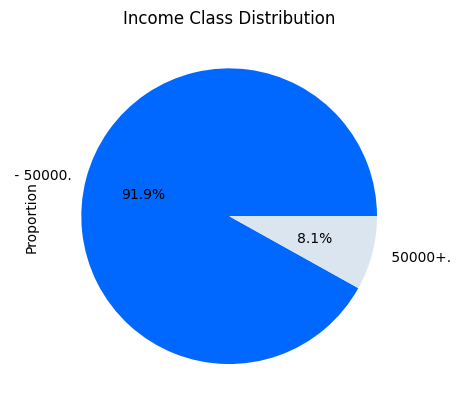

In [4]:
# Load Data and Add Columnn names
df = pd.read_csv('data/census_income_learn.csv', header=None, names=data_columns)

# Data Shape
print('(numbers of records, numbers of features ): ', df.shape, '\n')

#Drop uneeded column based on the meta data
df = df.drop(columns=['instance weight'])

#Describe Data with classes and number of unique values
col_analysis = []
for col in df.columns:
    unique_vals = df[col].unique()
    contains_question = ' ?' in unique_vals
    dtype = 'categorical' if df[col].dtype == 'object' else 'numerical'
    col_analysis.append({
        'column': col,
        'dtype': dtype,
        'contains_?': contains_question,
        'n_unique': len(unique_vals),
        'sample_values': unique_vals[:5]
    })
pd.DataFrame(col_analysis)

#fix wrong data types based on the meta data

incorrect_columns = [
    "industry code",
    "occupation code",
    "own business or self employed",
    "fill inc questionnaire for veteran's admin",
    "veterans benefits"
]

df[incorrect_columns] = df[incorrect_columns].astype('category')

print(df.dtypes)

#remove dup records
df = df[~df.duplicated()]

#handeling missing values

#1. Replace '?' with nan
df = df.replace(" ?", np.nan)
print('number of features before removing features with nan values above the threhold: ', df.shape)

#2. Calculate NaN values and their percentage in each column
nan_counts = df.isna().sum()
nan_percentages = (df.isna().mean() * 100).round(2)

#3. Create a DataFrame with NaN count and percentage information
nan_info = pd.DataFrame({'NaN Count': nan_counts, 'NaN Percentage': nan_percentages})

#4. Sort the DataFrame by 'NaN Percentage' in descending order
nan_info_sorted = nan_info.sort_values(by='NaN Percentage', ascending=False)

#5. Display sorted NaN counts and percentages
print("NaN counts and percentages sorted by percentage in each column:")
print(nan_info_sorted)

#6. Drop columns where NaN percentage exceeds 20%
threshold = 0.2
df = df.drop(columns=df.columns[df.isna().mean() > threshold])

print("\nDataFrame shape after dropping columns with NaN values exceeding", threshold * 100, "%:")

#7. Imput remaining nan values with mean for numerical and mode for categorical
for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype == 'category':
        df[col] = df[col].fillna(df[col].mode()[0])
    else:
        df[col] = df[col].fillna(df[col].median())

print(df.dtypes)

#add new feature for age
bins = [0, 18, 30, 40, 50, 60, 100]  # Bins for age
labels = ['0-18', '18-30', '30-40', '40-50', '50-60', '60+']
df['age_bin'] = pd.cut(df['age'], bins=bins, labels=labels)


#encode income class

label_encoder = LabelEncoder()
df['income_con'] = label_encoder.fit_transform(df['income'])

display(df['income_con'])

#Show classes distrebution

colors = [theme_colors_dict['accent1'], theme_colors_dict['accent2']]

print('Class distribution in income column:')
print(df['income'].value_counts())
df['income'].value_counts(normalize=True).plot(kind='pie', title='Income Class Distribution', colors=colors, autopct='%1.1f%%')
plt.ylabel('Proportion')  # Hide the y-label
plt.show()

In [5]:
#look at features and their values

for column in df.select_dtypes(['object', 'bool']).columns:
    print(f"Value counts for {column}:")
    print(df[column].value_counts())
    print("\n")

Value counts for class of worker:
class of worker
 Private                           71738
 Not in universe                   54165
 Self-employed-not incorporated     8321
 Local government                   7726
 State government                   4221
 Self-employed-incorporated         3259
 Federal government                 2920
 Never worked                        383
 Without pay                         163
Name: count, dtype: int64


Value counts for education:
education
 High school graduate                      43642
 Some college but no degree                26329
 Bachelors degree(BA AB BS)                19391
 Children                                  12710
 10th grade                                 6487
 Masters degree(MA MS MEng MEd MSW MBA)     6460
 7th and 8th grade                          6309
 11th grade                                 6213
 Associates degree-occup /vocational        5249
 9th grade                                  4976
 Associates degree-academ

numeric features distrebution


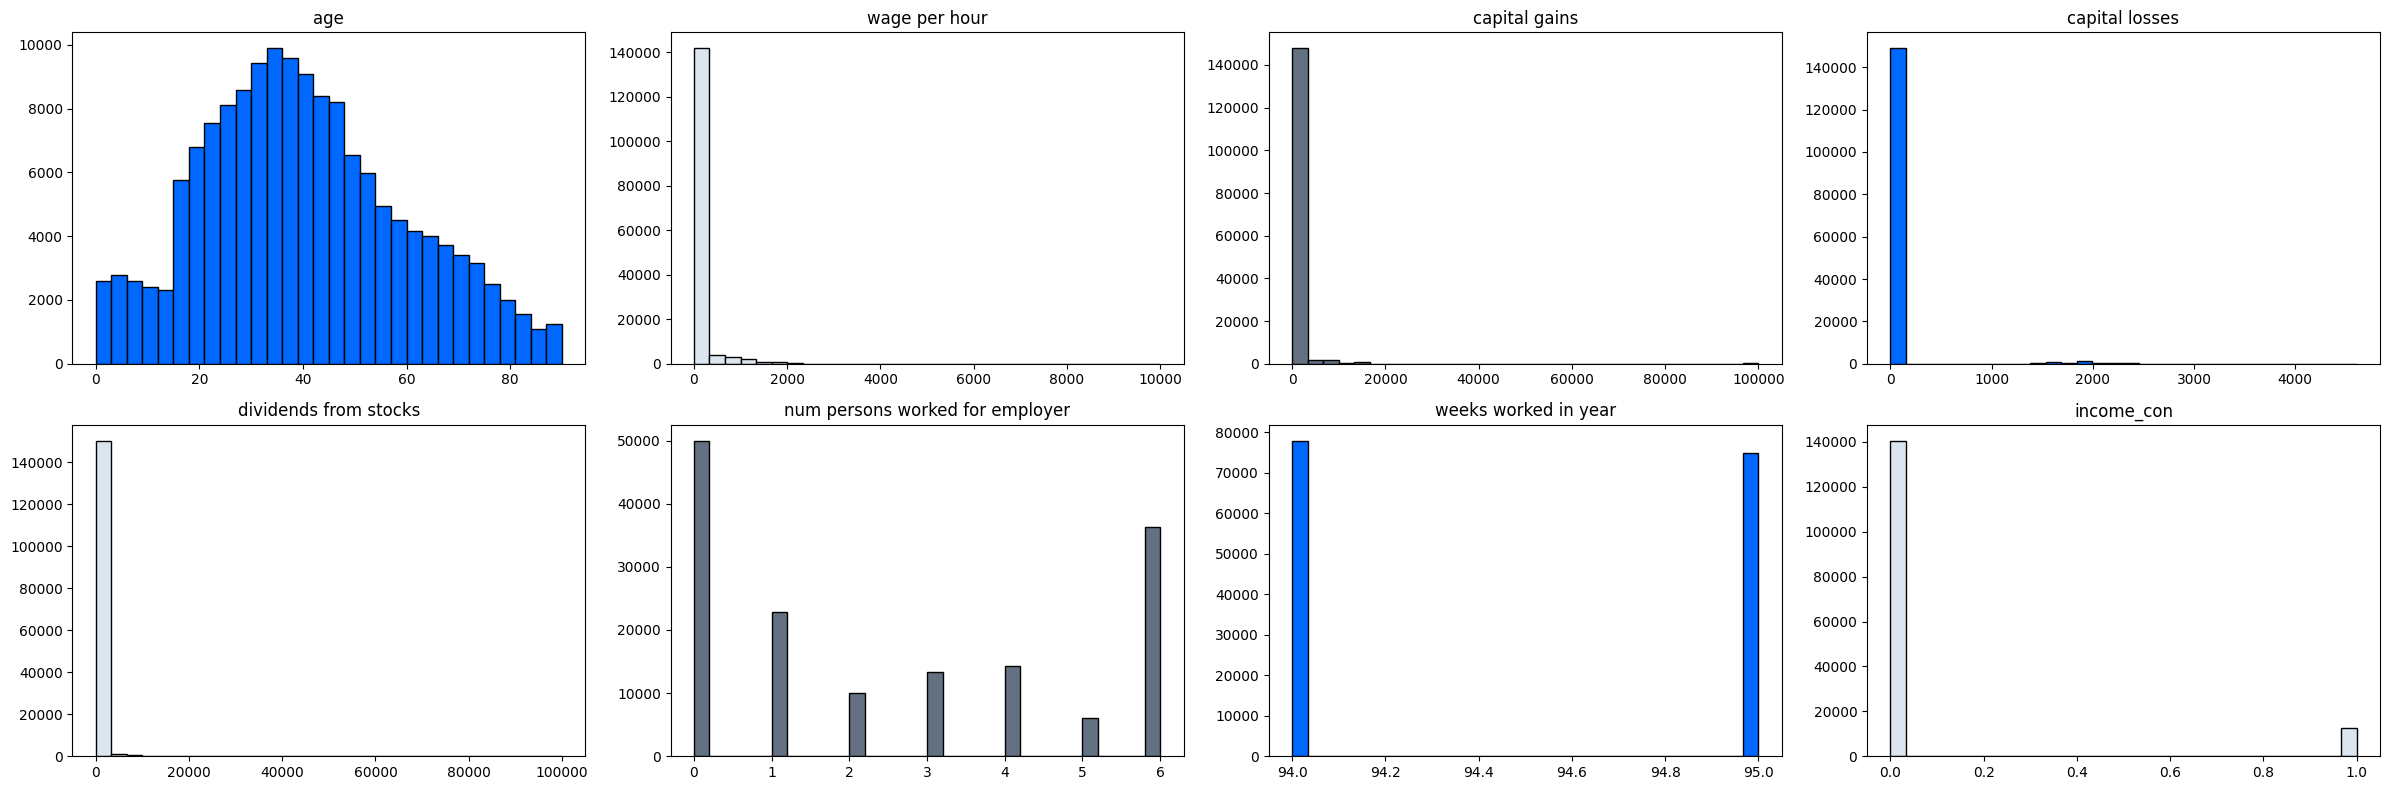

In [6]:
#Visualize Distributions of Numeric Features

print ('numeric features distrebution')
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
n_features = len(numeric_features)
n_cols = 4
n_rows = math.ceil(n_features / n_cols)

# Create a list of colors to cycle through (from the theme)
theme_colors = [
    theme_colors_dict['accent1'],
    theme_colors_dict['accent2'],
    theme_colors_dict['accent3']
]

# Ensure that the colors cycle if there are more features than available colors
colors = theme_colors * (n_features // len(theme_colors)) + theme_colors[:(n_features % len(theme_colors))]

# Plot the histograms
plt.figure(figsize=(n_cols * 6, n_rows * 4))

for i, col in enumerate(numeric_features, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.hist(df[col], bins=30, color=colors[i - 1], edgecolor='black')  # Assign color from the theme
    plt.title(col)

plt.tight_layout()
plt.show()


#Some continous values are sparse and need to be scaled

# Scaling Continuous Features
scaler = MinMaxScaler()

# List of continuous features to scale
continuous_cols = ['wage per hour', 'capital gains', 'capital losses', 'dividends from stocks']

# Apply scaling
df[continuous_cols] = scaler.fit_transform(df[continuous_cols])


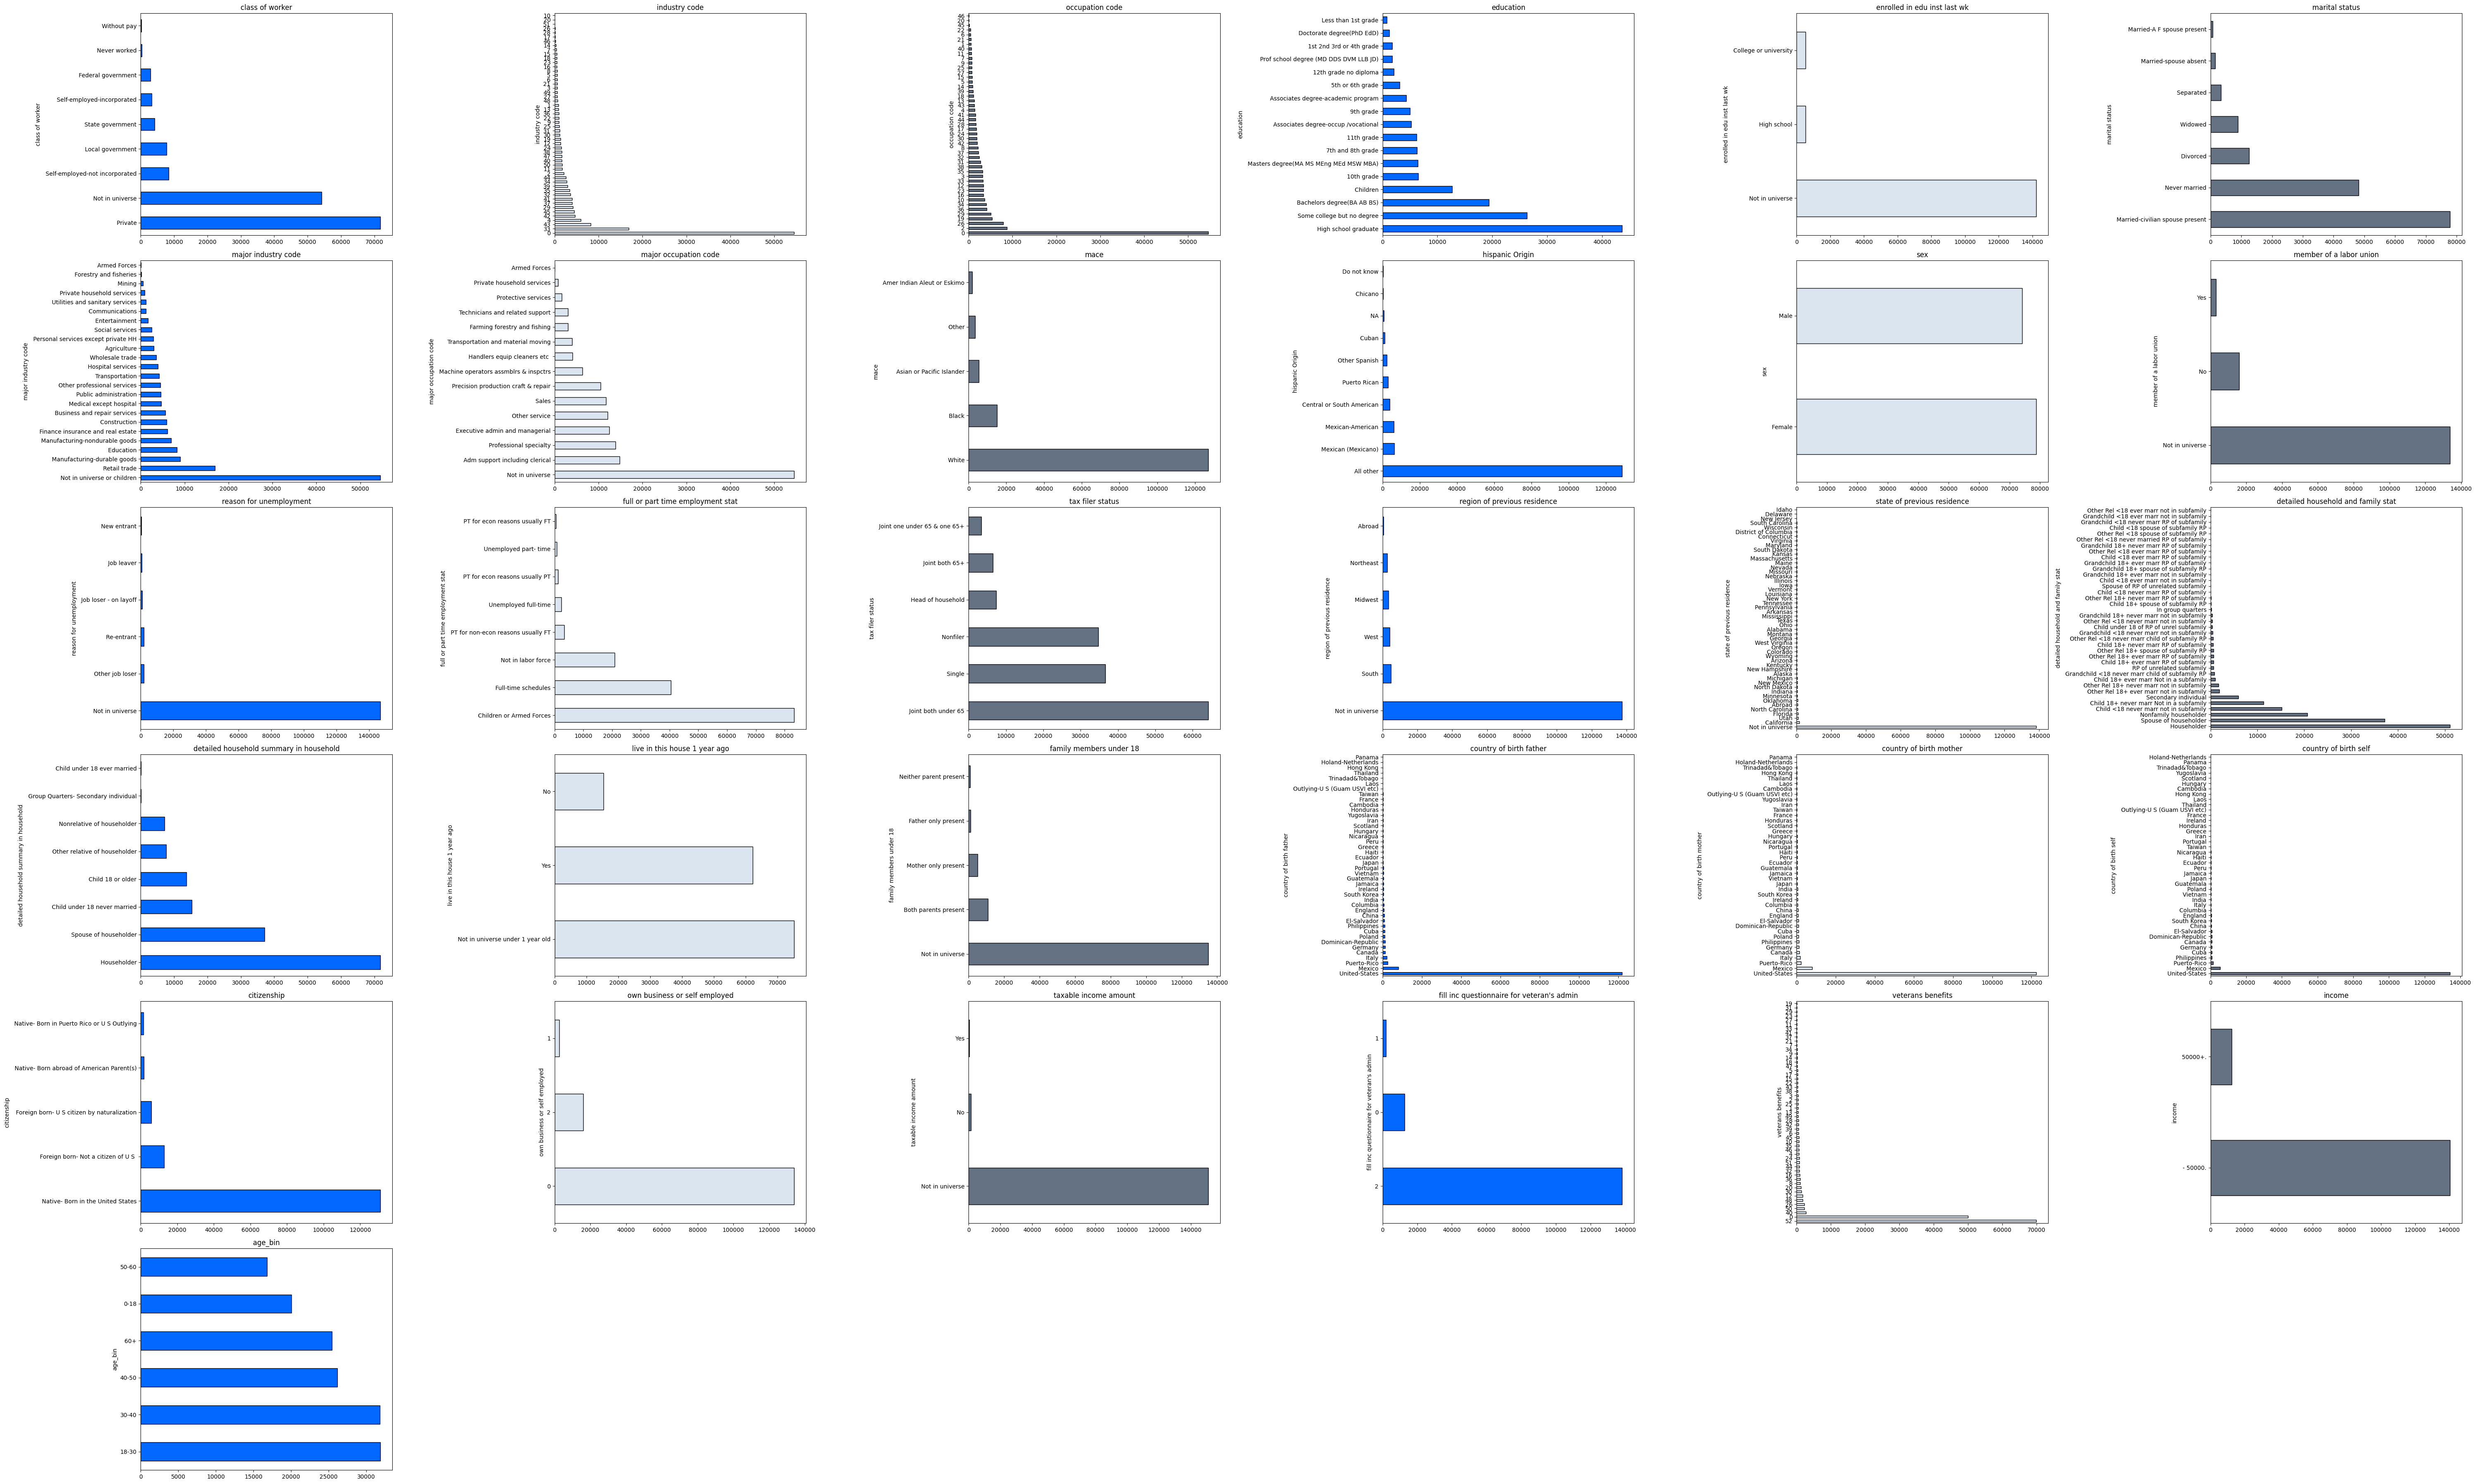

In [7]:
#Visualize Distributions Categorical Features

non_numeric_features = df.select_dtypes(exclude=['int64', 'float64']).columns
n_features = len(non_numeric_features)
n_cols = 6
n_rows = math.ceil(n_features / n_cols)

# Ensure that the colors cycle if there are more features than available colors
colors = theme_colors * (n_features // len(theme_colors)) + theme_colors[:(n_features % len(theme_colors))]

# Increase the figure size to prevent it from being cramped
plt.figure(figsize=(n_cols * 10, n_rows * 6))

# Plot the bar charts for categorical features
for i, col in enumerate(non_numeric_features, 1):
    plt.subplot(n_rows, n_cols, i)
    # Count the occurrences of each category and plot the bar chart (horizontal bars)
    df[col].value_counts().plot(kind='barh', color=colors[i - 1], edgecolor='black')
    plt.title(col)

plt.tight_layout()
plt.show()

In [8]:
print(df.dtypes)

age                                              int64
class of worker                                 object
industry code                                 category
occupation code                               category
education                                       object
wage per hour                                  float64
enrolled in edu inst last wk                    object
marital status                                  object
major industry code                             object
major occupation code                           object
mace                                            object
hispanic Origin                                 object
sex                                             object
member of a labor union                         object
reason for unemployment                         object
full or part time employment stat               object
capital gains                                  float64
capital losses                                 float64
dividends 

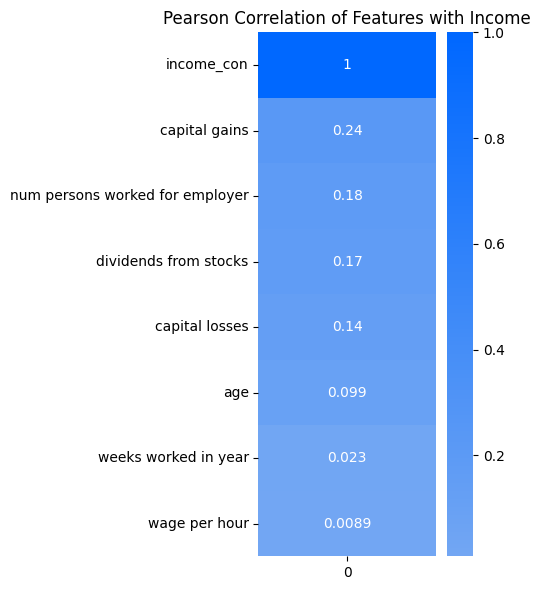

income_con                         1.000000
capital gains                      0.236337
num persons worked for employer    0.181049
dividends from stocks              0.170304
capital losses                     0.138698
age                                0.098788
weeks worked in year               0.022704
wage per hour                      0.008950
dtype: float64


In [9]:
#Show correlation of numerical features and income class

numerical_features = df.select_dtypes(include=['float64', 'int64'])

custom_cmap = LinearSegmentedColormap.from_list("custom_blue", [theme_colors_dict['lt2'], theme_colors_dict['accent1']])

# Select only numerical features, excluding 'income'
numerical_features = df.select_dtypes(include=['float64', 'int64'])

# Compute correlation with 'income' column
income_corr = numerical_features.corrwith(df['income_con']).sort_values(ascending=False)

# Plot the heatmap for correlation with 'income' using the custom blue gradient
plt.figure(figsize=(5, 6))  # Adjust figure size as needed
sns.heatmap(income_corr.to_frame(), annot=True, cmap=custom_cmap, center=0)
plt.title('Pearson Correlation of Features with Income')
plt.tight_layout()
plt.savefig('data/income_feature_corr_only_custom.png')
plt.show()

print(income_corr)

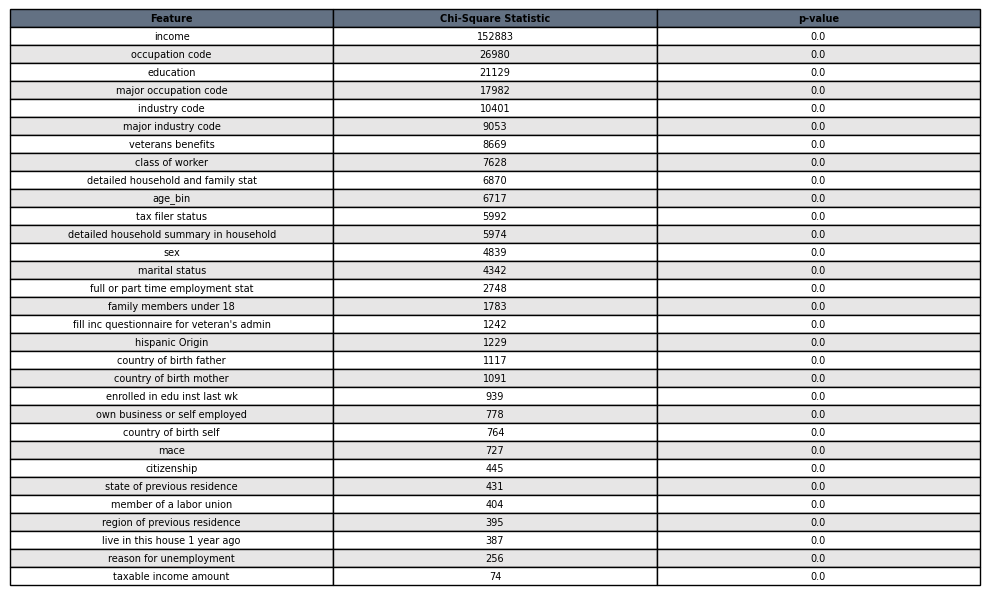

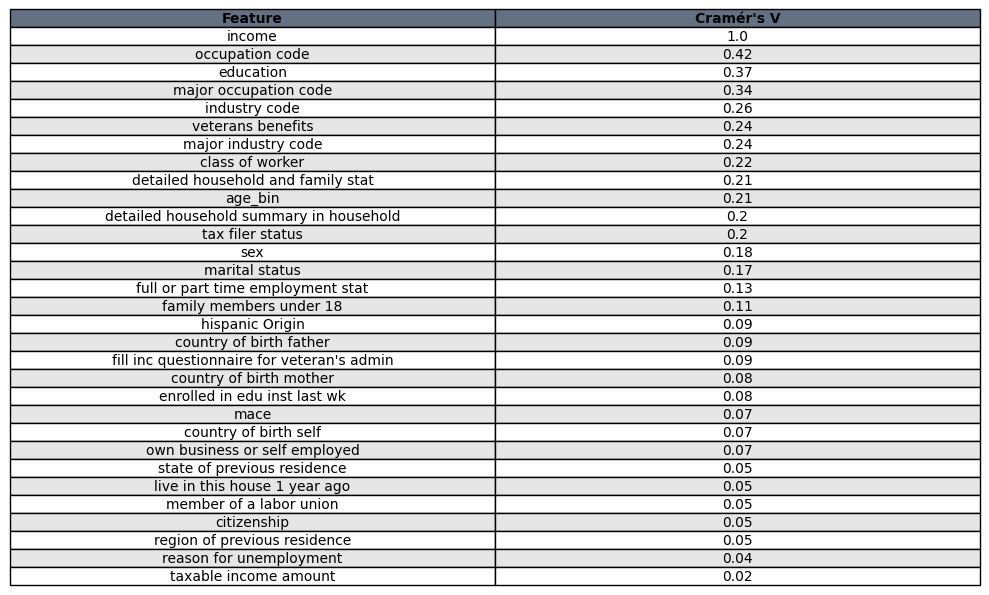

In [10]:
#show correlation of cateorical data

#use chi test
chi_square_results = []

# Perform Chi-Square test for each categorical feature
for feature in non_numeric_features:
    # Create a contingency table between the categorical feature and 'income'
    contingency_table = pd.crosstab(df[feature], df['income'])
    
    # Perform the Chi-Square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Store the results in the list
    chi_square_results.append({
        'Feature': feature,
        'Chi-Square Statistic': round(chi2),
        'p-value': round(p, 3)
    })

# Convert the results into a DataFrame
chi_square_df = pd.DataFrame(chi_square_results)

# Sort by Chi-Square Statistic for better readability
chi_square_df = chi_square_df.sort_values(by='Chi-Square Statistic', ascending=False)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Hide the axes (we're only displaying the table)
ax.axis('off')

# Create the table and apply color theme for styling
table = ax.table(cellText=chi_square_df.values, colLabels=chi_square_df.columns, loc='center', cellLoc='center', colColours=[theme_colors_dict['accent1']] * len(chi_square_df.columns))

# Apply background color for the header row
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_fontsize(12)
        cell.set_text_props(weight='bold')
        cell.set_facecolor(theme_colors_dict['accent3'])  # Header color
    else:
        # Apply alternating colors for the rows
        if i % 2 == 0:
            cell.set_facecolor(theme_colors_dict['lt2'])  # Light color for even rows
        else:
            cell.set_facecolor(theme_colors_dict['lt1'])  # Light color for odd rows
        cell.set_fontsize(14)

# Adjust table layout and save the figure
plt.tight_layout()
plt.savefig('data/chi_square_results_table.png')
plt.show()

# Compute Cramér's V for each categorical feature

# Function to calculate Cramér's V
def cramers_v(contingency_table):
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()  # Total number of observations
    k = min(contingency_table.shape)  # The smaller of number of rows or columns
    v = np.sqrt(chi2 / (n * (k - 1)))  # Cramér's V formula
    return v

# Initialize an empty list to store the Cramér's V results
cramers_v_results = []

# Perform Cramér's V calculation for each non-numeric feature
for feature in non_numeric_features:
    # Create a contingency table between the categorical feature and 'income'
    contingency_table = pd.crosstab(df[feature], df['income'])
    
    # Calculate Cramér's V
    cramer_v = cramers_v(contingency_table)
    
    # Store the results in the list
    cramers_v_results.append({
        'Feature': feature,
        'Cramér\'s V': round(cramer_v, 2)
    })

# Convert the results into a DataFrame
cramers_v_df = pd.DataFrame(cramers_v_results)

# Sort by Cramér's V for better readability
cramers_v_df = cramers_v_df.sort_values(by='Cramér\'s V', ascending=False)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Hide the axes (we're only displaying the table)
ax.axis('off')

# Create the table and apply color theme for styling
table = ax.table(cellText=cramers_v_df.values, colLabels=cramers_v_df.columns, loc='center', cellLoc='center', colColours=[theme_colors_dict['accent1']] * len(cramers_v_df.columns))

# Apply background color for the header row
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_fontsize(12)
        cell.set_text_props(weight='bold')
        cell.set_facecolor(theme_colors_dict['accent3'])  # Header color
    else:
        # Apply alternating colors for the rows
        if i % 2 == 0:
            cell.set_facecolor(theme_colors_dict['lt2'])  # Light color for even rows
        else:
            cell.set_facecolor(theme_colors_dict['lt1'])  # Light color for odd rows
        cell.set_fontsize(10)

# Adjust table layout and save the figure
plt.tight_layout()
plt.savefig('data/cramers_v_results_table.png')
plt.show()

## Data Modeling

In [11]:
# Prepare Data
X = df.drop(columns=['income', 'income_con'])
y = df['income_con']


# Process test set (same as df)
df_test = pd.read_csv('data/census_income_test.csv', header=None, names=data_columns)
df_test = df_test.drop(columns=['instance weight'])
df_test = df_test.replace(" ?", np.nan)

# Drop columns with >20% missing (same threshold as training)
df_test = df_test.drop(columns=df_test.columns[df_test.isna().mean() > 0.2])

# Impute remaining missing values
for col in df_test.columns:
    if df_test[col].dtype == 'object' or df_test[col].dtype.name == 'category':
        df_test[col] = df_test[col].fillna(df_test[col].mode()[0])
    else:
        df_test[col] = df_test[col].fillna(df_test[col].median())

# Add age bin and encoded income
df_test['age_bin'] = pd.cut(df_test['age'], bins=bins, labels=labels)
df_test['income_con'] = label_encoder.transform(df_test['income'])

X_test = df_test.drop(columns=['income', 'income_con'])
y_test = df_test['income_con']


cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
], remainder='passthrough')

# 2. Handle imbalance
scale_pos_weight = (len(y) - sum(y)) / sum(y)

# 3. Define Models
models = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000, class_weight='balanced'),
        'params': {'model__C': [1]}
    },
    'RandomForest': {
        'model': RandomForestClassifier(class_weight='balanced'),
        'params': {'model__n_estimators': [100], 'model__max_depth': [20]}
    },
    'XGBoost': {
        'model': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos_weight),
        'params': {'model__n_estimators': [100], 'model__max_depth': [5], 'model__learning_rate': [0.1]}
    }
}

# 4. Train and Evaluate
grid_results = {}
results = {}
roc_data = {}

for name, mp in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', mp['model'])
    ])
    grid = GridSearchCV(pipe, mp['params'], cv=3, scoring='roc_auc', n_jobs=-1)
    grid.fit(X, y)
    
    y_pred = grid.best_estimator_.predict(X_test)
    y_proba = grid.best_estimator_.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    
    grid_results[name] = grid
    results[name] = {
        'Model': name,
        'Best Parameters': grid.best_params_,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba)
    }
    roc_data[name] = (fpr, tpr, roc_auc_score(y_test, y_proba))

/home/nouf/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/nouf/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n


Model Evaluation Table:
                Model                                    Best Parameters  \
0  LogisticRegression                                    {'model__C': 1}   
1        RandomForest  {'model__max_depth': 20, 'model__n_estimators'...   
2             XGBoost  {'model__learning_rate': 0.1, 'model__max_dept...   

   Accuracy  F1 Score   ROC AUC  
0  0.815641  0.375229  0.879574  
1  0.881027  0.459985  0.937684  
2  0.822247  0.383179  0.924162  


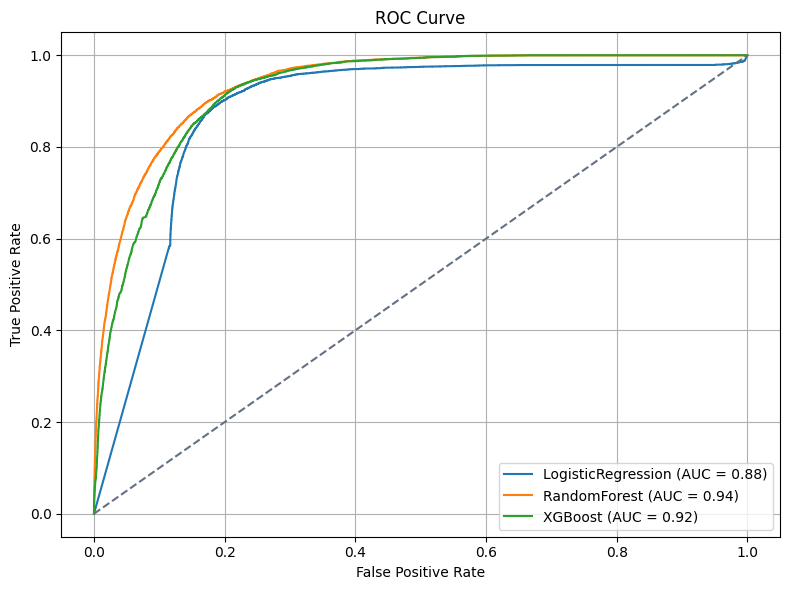


Best model selected for SHAP: RandomForest


In [12]:
# 5. Evaluation Table
results_df = pd.DataFrame(results).T.reset_index(drop=True)
print("\nModel Evaluation Table:")
print(results_df)

# 6. ROC Curve
plt.figure(figsize=(8, 6))
for name, (fpr, tpr, auc_val) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_val:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='#637183')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. SHAP Analysis (Best Model)
best_model_name = max(results, key=lambda k: results[k]['ROC AUC'])
best_model = grid_results[best_model_name].best_estimator_
print(f"\nBest model selected for SHAP: {best_model_name}")

# Ensure dense array for SHAP
X_transformed = best_model.named_steps['preprocessor'].transform(X_test)
if hasattr(X_transformed, "toarray"):
    X_transformed = X_transformed.toarray()

feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()


In [16]:
# Preprocess the test data
preprocessor = best_model.named_steps['preprocessor']
X_processed = preprocessor.transform(X_test)
if hasattr(X_processed, "toarray"):
    X_processed = X_processed.toarray()
feature_names = preprocessor.get_feature_names_out()

# Use permutation explainer
explainer = shap.Explainer(best_model.named_steps['model'].predict, X_processed)

# Fix: Set max_evals > 2*num_features
shap_values = explainer(X_processed, max_evals=1000)

# Plot SHAP values
shap.summary_plot(shap_values, X_processed, feature_names=feature_names)
shap.plots.bar(shap_values)


PermutationExplainer explainer:   1%|          | 1027/99762 [05:32<9:04:36,  3.02it/s] 


KeyboardInterrupt: 